In [14]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # disable oneDNN custom operations

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [15]:
import keras
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense
from keras.losses import MeanSquaredError
from keras.models import Sequential
from keras.optimizers import Adam

from romgw.config.env import PROJECT_ROOT
from romgw.deep_learning.io import load_raw_training_data, save_scaler, load_scaler
from romgw.deep_learning.preprocessing import train_val_split, make_x_scaler, make_y_scaler
from romgw.typing.core import BBHSpinType, ModeType, ComponentType
from romgw.typing.utils import validate_literal

In [16]:
bbh_spin: BBHSpinType = "NS"
mode: ModeType = "2,2"
component: ComponentType = "phase"
model_name = f"NonLinRegV1"

In [17]:
bbh_spin = validate_literal(bbh_spin, BBHSpinType)
mode = validate_literal(mode, ModeType)
component = validate_literal(component, ComponentType)

In [18]:
data_dir = PROJECT_ROOT / "data" / bbh_spin / "train" / mode / component
if not data_dir.is_dir():
    raise NotADirectoryError(f"Could not find the directory {data_dir}")

In [19]:
# ===== Preprocess data =====
X_raw, Y_raw = load_raw_training_data(bbh_spin, mode, component)

model_dir = data_dir / "models" / model_name
model_dir.mkdir(parents=True, exist_ok=True)

x_scaler = make_x_scaler(bbh_spin)
y_scaler = make_y_scaler(Y_raw)

save_scaler(x_scaler, "x", model_dir)
save_scaler(y_scaler, "y", model_dir)

x_scaler = load_scaler("x", model_dir)
y_scaler = load_scaler("y", model_dir)

X = x_scaler.transform(X_raw)
Y = y_scaler.transform(Y_raw)

X_train, X_val, Y_train, Y_val = train_val_split(X, Y)
print(f"{X_train.shape=}, {Y_train.shape=}")
print(f"{X_val.shape=}, {Y_val.shape=}")

Waveforms loaded.                                                               
X_train.shape=(3276, 1), Y_train.shape=(3276, 17)
X_val.shape=(820, 1), Y_val.shape=(820, 17)


In [21]:
# ===== Build model =====
n_xfeatures = X_train.shape[1]
n_yfeatures = Y_train.shape[1]

if component == "amplitude":
    model = Sequential([
        Dense(n_xfeatures, activation='linear'),
        Dense(32, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='sigmoid'),
        Dense(n_yfeatures, activation='linear')
    ])
else:  # if component == "phase"
    model = Sequential([
        Dense(n_xfeatures, activation='linear'),
        Dense(128, activation='sigmoid'),
        Dense(n_yfeatures, activation='linear')
    ])

In [22]:
# ----- Component-dependent kwargs -----
optimiser_kwargs = {
    "amplitude": {
        "epsilon": 1e-6,
        "learning_rate": 3e-2
    },
    "phase": {
        "epsilon": 1e-6,
        "learning_rate": 1e-2
    }
}
lrop_kwargs = {
    "amplitude": {
        "factor": 0.5,
        "patience": 32,
        "min_lr": 1e-10
    },
    "phase": {
        "factor": 0.5,
        "patience": 32,
        "min_lr": 1e-10
    }
}
early_stopping_kwargs = {
    "amplitude": {
        "patience": 256
    },
    "phase": {
        "patience": 256
    }
}
fit_kwargs = {
    "amplitude": {
        "epochs": 1000,
        "batch_size": 64
    },
    "phase": {
        "epochs": 1000,
        "batch_size": 64
    }
}

In [23]:
# ----- Model optimisers/callbacks -----
loss_fn = MeanSquaredError()

optimiser = Adam(**optimiser_kwargs[component])

lrop = ReduceLROnPlateau(monitor='val_loss', **lrop_kwargs[component])

early_stopping = EarlyStopping(monitor='val_loss',
                               **early_stopping_kwargs[component],
                               restore_best_weights=True)

model.compile(optimizer=optimiser, loss=loss_fn)

Epoch 1/1000
52/52 - 1s - 16ms/step - loss: 0.1333 - val_loss: 0.0470 - learning_rate: 0.0100
Epoch 2/1000
52/52 - 0s - 2ms/step - loss: 0.0273 - val_loss: 0.0160 - learning_rate: 0.0100
Epoch 3/1000
52/52 - 0s - 2ms/step - loss: 0.0164 - val_loss: 0.0151 - learning_rate: 0.0100
Epoch 4/1000
52/52 - 0s - 2ms/step - loss: 0.0160 - val_loss: 0.0153 - learning_rate: 0.0100
Epoch 5/1000
52/52 - 0s - 2ms/step - loss: 0.0161 - val_loss: 0.0165 - learning_rate: 0.0100
Epoch 6/1000
52/52 - 0s - 2ms/step - loss: 0.0161 - val_loss: 0.0168 - learning_rate: 0.0100
Epoch 7/1000
52/52 - 0s - 2ms/step - loss: 0.0159 - val_loss: 0.0184 - learning_rate: 0.0100
Epoch 8/1000
52/52 - 0s - 2ms/step - loss: 0.0167 - val_loss: 0.0148 - learning_rate: 0.0100
Epoch 9/1000
52/52 - 0s - 2ms/step - loss: 0.0158 - val_loss: 0.0163 - learning_rate: 0.0100
Epoch 10/1000
52/52 - 0s - 2ms/step - loss: 0.0167 - val_loss: 0.0151 - learning_rate: 0.0100
Epoch 11/1000
52/52 - 0s - 2ms/step - loss: 0.0156 - val_loss: 0.015

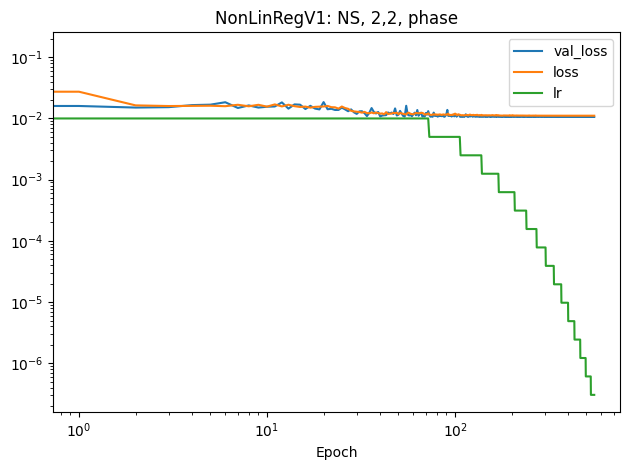

Saved training curve figure to /home/connor/projects/reduced-order-modelling-of-gravitational-waves/data/NS/train/2,2/phase/models/NonLinRegV1/training_curve.png


In [24]:
# ----- Train the model -----
history = model.fit(x=X_train,
                    y=Y_train,
                    validation_data=(X_val, Y_val),
                    **fit_kwargs[component],
                    callbacks=[lrop, early_stopping],
                    shuffle=True,
                    verbose=2)
print(f"Training of {model_name} complete.")

# ----- Visualise gradient descent -----
fig_file = model_dir / "training_curve.png"

fig, ax = plt.subplots(1, 1)

ax.loglog(history.history['val_loss'], label='val_loss')
ax.loglog(history.history['loss'], label='loss')
ax.loglog(history.history['learning_rate'], label='lr')

ax.set_title(f"{model_name}: {bbh_spin}, {mode}, {component}")
ax.set_xlabel("Epoch")
ax.legend()

fig.tight_layout()

plt.savefig(fig_file)
plt.show()
print(f"Saved training curve figure to {fig_file}")

In [25]:
# ===== Save model =====
model_file = model_dir / "model.keras"

model.save(filepath=model_file)
print(f"Saved model to {model_file}")

Saved model to /home/connor/projects/reduced-order-modelling-of-gravitational-waves/data/NS/train/2,2/phase/models/NonLinRegV1/model.keras


In [40]:
# def main(
#     model_name: str,
#     spin: str,
#     mode: str,
#     component: str,
#     optimiser_kwargs: Dict,
#     lrop_kwargs: Dict,
#     early_stopping_kwargs: Dict,
#     fit_kwargs: Dict
# ) -> None:
#     """"""


# if __name__ == "__main__":


#     main(model_name="NonLinRegV1",
#          spin="NS",
#          mode="2,2",
#          component="phase",
#          optimiser_kwargs=optimiser_kwargs,
#          lrop_kwargs=lrop_kwargs,
#          early_stopping_kwargs=early_stopping_kwargs,
#          fit_kwargs=fit_kwargs)